In [2]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2
#%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/osx-64/openjdk-11.0.1-hb0a8c7a_1021.tar.bz2
# install PySpark
%pip install pyspark

# install seaborn
%pip install seaborn

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done



## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-628f342d-7f0c-42a6-a67f-7ec25597f0c2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 567ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------

3.4.0


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 46692)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/opt/conda/lib/python3.11/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.11/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
       ^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_u

In [13]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [15]:
df = spark.read.csv(f'../../../data/csv/df_ml.csv', header = True)

In [16]:
df.columns

['_c0',
 'subreddit',
 'author',
 'id',
 'text',
 'num_comments',
 'score',
 'date',
 'sentiment',
 'is_biden',
 'is_trump',
 'trump_score',
 'biden_score',
 'is_hunter',
 'is_border',
 'is_war',
 'is_israel',
 'is_harris',
 'is_indictment',
 'is_administrationt']

In [17]:
df.show()

+---+------------+-------------------+-------+--------------------+------------+-----+----------+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+
|_c0|   subreddit|             author|     id|                text|num_comments|score|      date|sentiment|is_biden|is_trump|trump_score|biden_score|is_hunter|is_border|is_war|is_israel|is_harris|is_indictment|is_administrationt|
+---+------------+-------------------+-------+--------------------+------------+-----+----------+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+
|  0|  Republican| interestingfactoid|1dpu59h| say her name   c...|           2|   12|2024-06-27| positive|       1|       0|        0.0|  0.8331798|        0|        1|     0|        0|        0|            0|                 0|
|  1|    politics|    Plastic-Age5205|1bqxiww|biden expands win...|           9|

In [18]:
df.select("subreddit").distinct().show()

+------------+
|   subreddit|
+------------+
|  Republican|
|     Liberal|
|    politics|
| Libertarian|
|   democrats|
|Conservative|
+------------+



In [19]:
from pyspark.sql.functions import concat_ws, col, year, month, regexp_replace, when, lit, udf

df = df \
    .withColumn('num_comments', col('num_comments').cast("integer")) \
    .withColumn('score', col('score').cast("integer")) \
    .withColumn('date', col('date').cast("date")) \
    .withColumn('is_biden', col('is_biden').cast("integer")) \
    .withColumn('is_trump', col('is_trump').cast("integer")) \
    .withColumn('is_hunter', col('is_hunter').cast("integer")) \
    .withColumn('is_border', col('is_border').cast("integer")) \
    .withColumn('is_war', col('is_war').cast("integer")) \
    .withColumn('is_israel', col('is_israel').cast("integer")) \
    .withColumn('is_harris', col('is_harris').cast("integer")) \
    .withColumn('is_indictment', col('is_indictment').cast("integer")) \
    .withColumn("year", year(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .withColumn("clean_text", regexp_replace(col("text"), "[^a-zA-Z0-9\s]", "")) \
    .withColumn("score_label",
                when(col("score") == 0, 0)
                .when(col("score") == 1, 1)
                .when((col("score") >= 2) & (col("score") < 10), 2)
                .when((col("score") >= 10) & (col("score") < 100), 3)
                .when((col("score") >= 100) & (col("score") < 1000), 4)
                .otherwise(5)
        ) \
    .drop(*['_c0', 'id', 'date'])

In [20]:
df.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_biden: integer (nullable = true)
 |-- is_trump: integer (nullable = true)
 |-- trump_score: string (nullable = true)
 |-- biden_score: string (nullable = true)
 |-- is_hunter: integer (nullable = true)
 |-- is_border: integer (nullable = true)
 |-- is_war: integer (nullable = true)
 |-- is_israel: integer (nullable = true)
 |-- is_harris: integer (nullable = true)
 |-- is_indictment: integer (nullable = true)
 |-- is_administrationt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- score_label: integer (nullable = false)



In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = df.toPandas()

In [22]:
target_column = 'num_comments' 
features = ['author', 'score', 'sentiment', 
            'is_trump', 'is_harris', 'is_biden', 'is_indictment', 'is_border',
            'is_war', 'is_israel', 'is_hunter']

df['author'] = df['author'].astype('category').cat.codes
df['sentiment'] = df['sentiment'].astype('category').cat.codes

df['num_comments_class'] = pd.qcut(
    df['num_comments'], 
    q=3, 
    labels=False, 
    duplicates='drop'  
)

target_column = 'num_comments_class'

X = df[features]
y = df[target_column]

y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

import numpy as np
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

y_prob = clf.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     11363
           1       0.32      0.26      0.29      2398
           2       0.77      0.80      0.79      6711

    accuracy                           0.76     20472
   macro avg       0.64      0.64      0.64     20472
weighted avg       0.76      0.76      0.76     20472



In [23]:
# Save results
preds_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'y_prob': y_prob.tolist()
})

preds_df.to_csv('../../../data/models/num_comments/results/preds_df.csv', index=False)

In [24]:
color_map = {
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Conservative": "pink",
    "Libertarian": "gold",
    "politics": "green",
    
}

color_list = list(color_map.values())

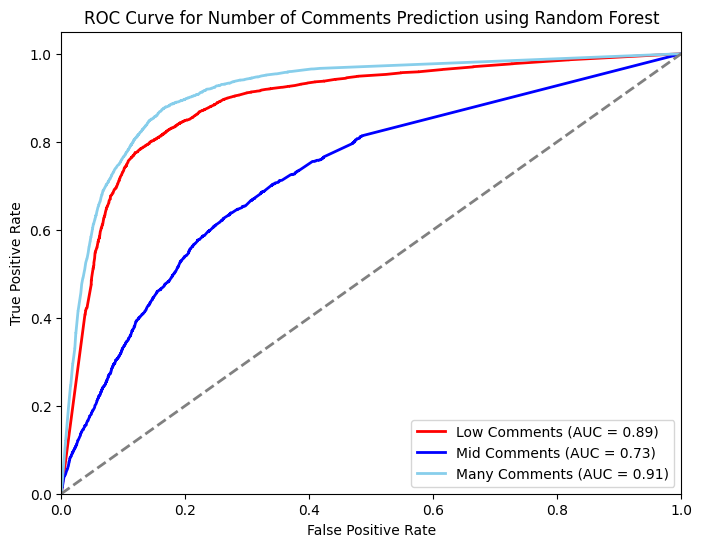

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

y_prob = clf.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
class_names = ['Low Comments','Mid Comments', 'Many Comments']  
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})', color=color_list[i])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Number of Comments Prediction using Random Forest')
plt.legend(loc='lower right')
plt.savefig('num_comments_roc.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()


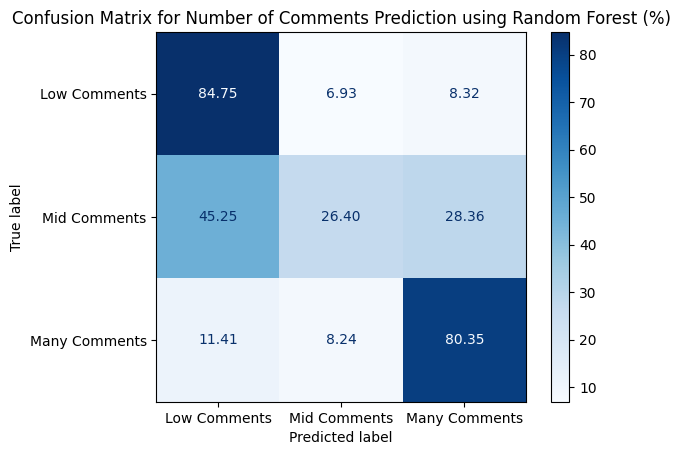

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2f')

plt.title('Confusion Matrix for Number of Comments Prediction using Random Forest (%)')
plt.savefig('num_comments_conf.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
feature_importances = clf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
1           score    0.622140
0          author    0.350488
2       sentiment    0.007248
5        is_biden    0.003410
3        is_trump    0.003137
8          is_war    0.002965
4       is_harris    0.002724
7       is_border    0.002307
10      is_hunter    0.002203
9       is_israel    0.001894
6   is_indictment    0.001485


In [28]:
feature_importance_df['clean_names'] = [
    'Score',
    'Author',
    'Sentiment',
    'Mentions Biden',
    'Mentions Trump',
    'Mentions War',
    'Mentions Harris',
    'Mentions border',
    'Mentions Hunter Biden',
    'Mentions Israel',
    'Mentions Indictment'
]

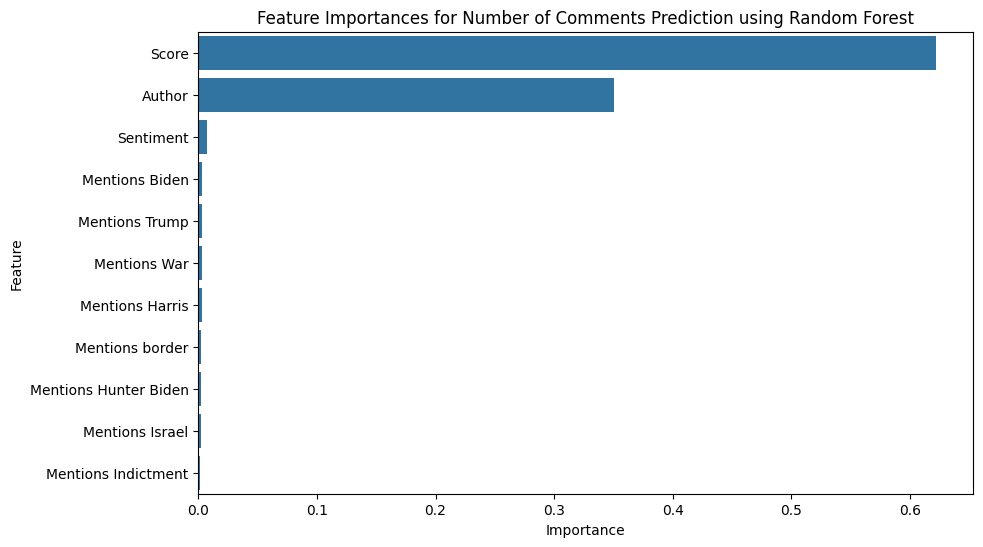

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='clean_names', data=feature_importance_df)

plt.title('Feature Importances for Number of Comments Prediction using Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig("comments_feature_importances", bbox_inches='tight', dpi=300)
plt.show()

In [30]:
import pandas as pd
results = pd.read_csv("../../../data/models/num_comments/results/preds_df.csv")

In [31]:
from sklearn.metrics import classification_report
report = classification_report(results['y_test'], results['y_pred'], output_dict=True)

overall_metrics = pd.DataFrame(index=["accuracy", "precision", "recall", "f1-score", "support"],columns=["value"])
overall_metrics.loc["accuracy"] = report["accuracy"]
overall_metrics.loc["precision"] = report["macro avg"]["precision"]
overall_metrics.loc["recall"] = report["macro avg"]["recall"]
overall_metrics.loc["f1-score"] = report["macro avg"]["f1-score"]
overall_metrics.loc["support"] = report["macro avg"]["support"]

print(overall_metrics)

overall_metrics.to_csv("../../../data/models/num_comments/results/overall_metrics.csv")

              value
accuracy   0.764703
precision  0.642622
recall     0.638305
f1-score   0.639409
support     20472.0
